# Importaciones

In [1]:
from imports import *                    # pandas, numpy, etc.
from trading_environment import (
    DataManager,
    Optimizer,
    PerformanceAnalyzer,
    ReportManager,
    RiskManager,
    DATA_DIR,
    MAX_FILE_SIZE,
    REPORT_DIR
)
from strategies import (
    MovingAverageCrossStrategy,
    DcaStrategy,
    DonchianBreakoutStrategy,
    ADXTrendStrategy,
    ROCStrategy,
    MACDStrategy,
    BollingerMeanRevStrategy,
    RSIStrategy,
    PairTradingStrategy,
    VWAPStrategy
)

# Strategies

In [ ]:
from imports import *
from trading_environment import (
    DataManager,
    Optimizer,
    PerformanceAnalyzer,
    ReportManager,
    DATA_DIR,
    MAX_FILE_SIZE,
    REPORT_DIR
)
from strategies import (
    MovingAverageCrossStrategy,
    DcaStrategy,
    DonchianBreakoutStrategy,
    ADXTrendStrategy,
    ROCStrategy,
    MACDStrategy,
    BollingerMeanRevStrategy,
    RSIStrategy,
    PairTradingStrategy,
    VWAPStrategy
)

# 1) Load data
dm = DataManager(data_dir=DATA_DIR, max_file_size=MAX_FILE_SIZE)
data = dm.load_data(
    symbols='BTC-USD',
    period='2y',
    interval='1d'
)

2025-06-25 07:59:28,150 - INFO - Descargando tickers=['BTC-USD'], start=None, end=None, period=2y, interval=1d
2025-06-25 07:59:28,570 - INFO - Guardado caché data\BTC-USD_2y_1d_part1.csv (731 filas)
2025-06-25 07:59:28,596 - WARNING - Grid skip {'short_window': 50, 'long_window': 50}: short_window debe ser menor que long_window
[I 2025-06-25 07:59:28,606] A new study created in memory with name: no-name-0e684ef1-c457-4b06-a015-b155e0d78a73
[I 2025-06-25 07:59:28,611] Trial 0 finished with value: 0.8964904256067173 and parameters: {'short_window': 22, 'long_window': 193}. Best is trial 0 with value: 0.8964904256067173.
[I 2025-06-25 07:59:28,616] Trial 1 finished with value: 0.32839225269929856 and parameters: {'short_window': 38, 'long_window': 140}. Best is trial 1 with value: 0.32839225269929856.
[I 2025-06-25 07:59:28,621] Trial 2 finished with value: 0.044547924709997744 and parameters: {'short_window': 12, 'long_window': 73}. Best is trial 2 with value: 0.044547924709997744.
[I 2


Processing strategy type: MA Cross
  Grid best    — Sharpe 0.6428 with {'short_window': 5, 'long_window': 50}


[I 2025-06-25 07:59:28,766] Trial 18 finished with value: -1.0493499674621607 and parameters: {'short_window': 37, 'long_window': 123}. Best is trial 18 with value: -1.0493499674621607.
[I 2025-06-25 07:59:28,779] Trial 19 finished with value: -0.5977988764577092 and parameters: {'short_window': 38, 'long_window': 114}. Best is trial 18 with value: -1.0493499674621607.
[I 2025-06-25 07:59:28,790] Trial 20 finished with value: -0.5411299557780093 and parameters: {'short_window': 38, 'long_window': 102}. Best is trial 18 with value: -1.0493499674621607.
[I 2025-06-25 07:59:28,802] Trial 21 finished with value: -0.6225559083754476 and parameters: {'short_window': 39, 'long_window': 110}. Best is trial 18 with value: -1.0493499674621607.
[I 2025-06-25 07:59:28,813] Trial 22 finished with value: -1.2153966969623744 and parameters: {'short_window': 49, 'long_window': 121}. Best is trial 22 with value: -1.2153966969623744.
[I 2025-06-25 07:59:28,825] Trial 23 finished with value: -0.497559710

  Bayesian best— Sharpe 1.2154 with {'short_window': 49, 'long_window': 121}


[I 2025-06-25 07:59:29,810] A new study created in memory with name: no-name-d5bcf4cc-5969-40a3-8a88-3eb23035985b
[I 2025-06-25 07:59:29,827] Trial 0 finished with value: -1.268450538807316 and parameters: {'amount': 1062, 'freq': 'D'}. Best is trial 0 with value: -1.268450538807316.
[I 2025-06-25 07:59:29,827] Trial 1 finished with value: -1.1094549145582329 and parameters: {'amount': 734, 'freq': 'M'}. Best is trial 0 with value: -1.268450538807316.
[I 2025-06-25 07:59:29,841] Trial 2 finished with value: -1.275832608466587 and parameters: {'amount': 1402, 'freq': 'M'}. Best is trial 2 with value: -1.275832608466587.
[I 2025-06-25 07:59:29,860] Trial 3 finished with value: -1.2721959539626233 and parameters: {'amount': 1749, 'freq': 'D'}. Best is trial 2 with value: -1.275832608466587.
[I 2025-06-25 07:59:29,880] Trial 4 finished with value: -1.2682140814306626 and parameters: {'amount': 956, 'freq': 'D'}. Best is trial 2 with value: -1.275832608466587.
[I 2025-06-25 07:59:29,886] Tr

  DE best      — Sharpe 1.3476 with {'short_window': 15, 'long_window': 191}

Processing strategy type: DCA
  Grid best    — Sharpe 1.3454 with {'amount': 500, 'freq': 'W'}


[I 2025-06-25 07:59:29,913] Trial 7 finished with value: -1.2894512826736972 and parameters: {'amount': 1389, 'freq': 'W'}. Best is trial 7 with value: -1.2894512826736972.
[I 2025-06-25 07:59:29,921] Trial 8 finished with value: -1.3591159880549712 and parameters: {'amount': 597, 'freq': 'W'}. Best is trial 8 with value: -1.3591159880549712.
[I 2025-06-25 07:59:29,929] Trial 9 finished with value: -1.3236609791436091 and parameters: {'amount': 957, 'freq': 'W'}. Best is trial 8 with value: -1.3591159880549712.
[I 2025-06-25 07:59:29,940] Trial 10 finished with value: -1.352726921234426 and parameters: {'amount': 530, 'freq': 'W'}. Best is trial 8 with value: -1.3591159880549712.
[I 2025-06-25 07:59:29,951] Trial 11 finished with value: -1.3481283219744602 and parameters: {'amount': 511, 'freq': 'W'}. Best is trial 8 with value: -1.3591159880549712.
[I 2025-06-25 07:59:29,963] Trial 12 finished with value: -1.3506002989662913 and parameters: {'amount': 521, 'freq': 'W'}. Best is trial 

  Bayesian best— Sharpe 1.3597 with {'amount': 585, 'freq': 'W'}
Skipping DE: non-numeric parameters present

Processing strategy type: Donchian
  Grid best    — Sharpe 1.0000 with {'window': 50}


[I 2025-06-25 07:59:30,510] Trial 28 finished with value: -0.7945081934369819 and parameters: {'window': 41}. Best is trial 1 with value: -1.0000252708565318.
[I 2025-06-25 07:59:30,519] Trial 29 finished with value: -0.6799399332921496 and parameters: {'window': 25}. Best is trial 1 with value: -1.0000252708565318.
[I 2025-06-25 07:59:30,526] Trial 30 finished with value: -1.0000252708565318 and parameters: {'window': 48}. Best is trial 1 with value: -1.0000252708565318.
[I 2025-06-25 07:59:30,534] Trial 31 finished with value: -1.0000252708565318 and parameters: {'window': 50}. Best is trial 1 with value: -1.0000252708565318.
[I 2025-06-25 07:59:30,541] Trial 32 finished with value: -1.0000252708565318 and parameters: {'window': 50}. Best is trial 1 with value: -1.0000252708565318.
[I 2025-06-25 07:59:30,549] Trial 33 finished with value: -0.8345351971294706 and parameters: {'window': 43}. Best is trial 1 with value: -1.0000252708565318.
[I 2025-06-25 07:59:30,556] Trial 34 finished 

  Bayesian best— Sharpe 1.0000 with {'window': 48}
  DE best      — Sharpe 1.0000 with {'window': 49}

Processing strategy type: ADX + MA
  Grid best    — Sharpe 0.9763 with {'short_w': 5, 'long_w': 100, 'adx_w': 14}


[W 2025-06-25 07:59:30,786] Trial 3 failed with parameters: {'short_w': 16, 'long_w': 51, 'adx_w': 20} because of the following error: The value nan is not acceptable.
[W 2025-06-25 07:59:30,787] Trial 3 failed with value nan.
[I 2025-06-25 07:59:30,800] Trial 4 finished with value: 0.38008041297080464 and parameters: {'short_w': 18, 'long_w': 60, 'adx_w': 15}. Best is trial 1 with value: -0.8307237261493917.
[I 2025-06-25 07:59:30,812] Trial 5 finished with value: 0.5871398829359687 and parameters: {'short_w': 7, 'long_w': 65, 'adx_w': 17}. Best is trial 1 with value: -0.8307237261493917.
[W 2025-06-25 07:59:30,822] Trial 6 failed with parameters: {'short_w': 11, 'long_w': 64, 'adx_w': 18} because of the following error: The value nan is not acceptable.
[W 2025-06-25 07:59:30,823] Trial 6 failed with value nan.
[I 2025-06-25 07:59:30,834] Trial 7 finished with value: 0.5871398829359687 and parameters: {'short_w': 7, 'long_w': 64, 'adx_w': 16}. Best is trial 1 with value: -0.8307237261

  Bayesian best— Sharpe 0.9575 with {'short_w': 14, 'long_w': 97, 'adx_w': 14}


[I 2025-06-25 07:59:34,342] A new study created in memory with name: no-name-ccb6d1cc-928b-4aa1-90e7-116d48990c2e
[I 2025-06-25 07:59:34,346] Trial 0 finished with value: 0.056462718334251885 and parameters: {'window': 10}. Best is trial 0 with value: 0.056462718334251885.
[I 2025-06-25 07:59:34,350] Trial 1 finished with value: -0.49082981537948944 and parameters: {'window': 20}. Best is trial 1 with value: -0.49082981537948944.
[I 2025-06-25 07:59:34,353] Trial 2 finished with value: -0.22949370294458163 and parameters: {'window': 16}. Best is trial 1 with value: -0.49082981537948944.
[I 2025-06-25 07:59:34,357] Trial 3 finished with value: -0.6558225926470798 and parameters: {'window': 14}. Best is trial 3 with value: -0.6558225926470798.
[I 2025-06-25 07:59:34,360] Trial 4 finished with value: 0.3732102638441881 and parameters: {'window': 7}. Best is trial 3 with value: -0.6558225926470798.
[I 2025-06-25 07:59:34,364] Trial 5 finished with value: 0.3732102638441881 and parameters: 

  DE           — failed (cannot convert float NaN to integer)

Processing strategy type: ROC
  Grid best    — Sharpe 0.4908 with {'window': 20}


[I 2025-06-25 07:59:34,515] Trial 30 finished with value: -0.4976331683907521 and parameters: {'window': 15}. Best is trial 3 with value: -0.6558225926470798.
[I 2025-06-25 07:59:34,522] Trial 31 finished with value: -0.6558225926470798 and parameters: {'window': 14}. Best is trial 3 with value: -0.6558225926470798.
[I 2025-06-25 07:59:34,530] Trial 32 finished with value: -0.157480473773227 and parameters: {'window': 13}. Best is trial 3 with value: -0.6558225926470798.
[I 2025-06-25 07:59:34,537] Trial 33 finished with value: -0.6558225926470798 and parameters: {'window': 14}. Best is trial 3 with value: -0.6558225926470798.
[I 2025-06-25 07:59:34,544] Trial 34 finished with value: 0.05045428101761569 and parameters: {'window': 11}. Best is trial 3 with value: -0.6558225926470798.
[I 2025-06-25 07:59:34,551] Trial 35 finished with value: -0.5975655596691503 and parameters: {'window': 17}. Best is trial 3 with value: -0.6558225926470798.
[I 2025-06-25 07:59:34,557] Trial 36 finished w

  Bayesian best— Sharpe 0.6558 with {'window': 14}
  DE best      — Sharpe 0.5976 with {'window': 17}

Processing strategy type: MACD
  Grid best    — Sharpe 0.0209 with {'fast': 12, 'slow': 26, 'signal': 12}


[I 2025-06-25 07:59:34,768] Trial 14 finished with value: 0.11035839757550592 and parameters: {'fast': 9, 'slow': 28, 'signal': 12}. Best is trial 8 with value: 0.007431442367643236.
[I 2025-06-25 07:59:34,783] Trial 15 finished with value: -0.006370438677111185 and parameters: {'fast': 11, 'slow': 29, 'signal': 10}. Best is trial 15 with value: -0.006370438677111185.
[I 2025-06-25 07:59:34,796] Trial 16 finished with value: 0.11477244875833281 and parameters: {'fast': 9, 'slow': 29, 'signal': 9}. Best is trial 15 with value: -0.006370438677111185.
[I 2025-06-25 07:59:34,810] Trial 17 finished with value: 0.31952856952422676 and parameters: {'fast': 12, 'slow': 30, 'signal': 10}. Best is trial 15 with value: -0.006370438677111185.
[I 2025-06-25 07:59:34,824] Trial 18 finished with value: 0.6941762163609818 and parameters: {'fast': 11, 'slow': 28, 'signal': 9}. Best is trial 15 with value: -0.006370438677111185.
[I 2025-06-25 07:59:34,837] Trial 19 finished with value: 0.117893087738883

  Bayesian best— Sharpe 0.1560 with {'fast': 10, 'slow': 28, 'signal': 12}


[I 2025-06-25 07:59:36,118] A new study created in memory with name: no-name-4754feed-491b-4e6b-bc91-1c10b6a7f4a5
[I 2025-06-25 07:59:36,122] Trial 0 finished with value: -0.15515861511050555 and parameters: {'window': 14, 'n_std': 1.5}. Best is trial 0 with value: -0.15515861511050555.
[I 2025-06-25 07:59:36,126] Trial 1 finished with value: 0.6282964343358968 and parameters: {'window': 11, 'n_std': 2.5}. Best is trial 0 with value: -0.15515861511050555.
[I 2025-06-25 07:59:36,131] Trial 2 finished with value: 0.6908429560375505 and parameters: {'window': 16, 'n_std': 2.5}. Best is trial 0 with value: -0.15515861511050555.
[I 2025-06-25 07:59:36,135] Trial 3 finished with value: 0.015623711604176081 and parameters: {'window': 19, 'n_std': 1.5}. Best is trial 0 with value: -0.15515861511050555.
[I 2025-06-25 07:59:36,140] Trial 4 finished with value: -0.014044188906555193 and parameters: {'window': 13, 'n_std': 1.5}. Best is trial 0 with value: -0.15515861511050555.
[I 2025-06-25 07:59

  DE best      — Sharpe 0.2414 with {'fast': 12, 'slow': 28, 'signal': 10}

Processing strategy type: BB Mean Reversion
  Grid best    — Sharpe -0.0181 with {'window': 20, 'n_std': 1.5}


[I 2025-06-25 07:59:36,280] Trial 24 finished with value: 0.2727437594280534 and parameters: {'window': 10, 'n_std': 1.5}. Best is trial 15 with value: -0.29809927888950805.
[I 2025-06-25 07:59:36,288] Trial 25 finished with value: -0.29809927888950805 and parameters: {'window': 12, 'n_std': 1.5}. Best is trial 15 with value: -0.29809927888950805.
[I 2025-06-25 07:59:36,296] Trial 26 finished with value: -0.09760455011921536 and parameters: {'window': 15, 'n_std': 1.5}. Best is trial 15 with value: -0.29809927888950805.
[I 2025-06-25 07:59:36,304] Trial 27 finished with value: -0.14391658577862534 and parameters: {'window': 11, 'n_std': 1.5}. Best is trial 15 with value: -0.29809927888950805.
[I 2025-06-25 07:59:36,313] Trial 28 finished with value: 0.5514652391388689 and parameters: {'window': 17, 'n_std': 2.5}. Best is trial 15 with value: -0.29809927888950805.
[I 2025-06-25 07:59:36,320] Trial 29 finished with value: 0.4217290625538142 and parameters: {'window': 13, 'n_std': 2}. Bes

  Bayesian best— Sharpe 0.2981 with {'window': 12, 'n_std': 1.5}


[I 2025-06-25 07:59:36,910] A new study created in memory with name: no-name-1cc5e6d6-5c16-41c7-9cab-34ede87cda3e
[I 2025-06-25 07:59:36,915] Trial 0 finished with value: 0.9695879323538565 and parameters: {'window': 14, 'low': 30, 'high': 70}. Best is trial 0 with value: 0.9695879323538565.
[I 2025-06-25 07:59:36,919] Trial 1 finished with value: 0.8436784326861106 and parameters: {'window': 20, 'low': 30, 'high': 70}. Best is trial 1 with value: 0.8436784326861106.
[I 2025-06-25 07:59:36,924] Trial 2 finished with value: 1.0083417730965 and parameters: {'window': 18, 'low': 30, 'high': 70}. Best is trial 1 with value: 0.8436784326861106.
[I 2025-06-25 07:59:36,930] Trial 3 finished with value: 0.8963249213626295 and parameters: {'window': 16, 'low': 30, 'high': 70}. Best is trial 1 with value: 0.8436784326861106.
[I 2025-06-25 07:59:36,934] Trial 4 finished with value: 0.5147072137710954 and parameters: {'window': 11, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.514707213771

  DE best      — Sharpe 0.5802 with {'window': 14, 'n_std': 1.6308128088423213}

Processing strategy type: RSI
  Grid best    — Sharpe -0.5886 with {'window': 10, 'low': 30, 'high': 70}


[I 2025-06-25 07:59:37,094] Trial 24 finished with value: 0.5147072137710954 and parameters: {'window': 11, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.5147072137710954.
[I 2025-06-25 07:59:37,102] Trial 25 finished with value: 0.7323060689647752 and parameters: {'window': 12, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.5147072137710954.
[I 2025-06-25 07:59:37,110] Trial 26 finished with value: 0.5885566740166142 and parameters: {'window': 10, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.5147072137710954.
[I 2025-06-25 07:59:37,120] Trial 27 finished with value: 1.016811642499667 and parameters: {'window': 15, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.5147072137710954.
[I 2025-06-25 07:59:37,128] Trial 28 finished with value: 0.5147072137710954 and parameters: {'window': 11, 'low': 30, 'high': 70}. Best is trial 4 with value: 0.5147072137710954.
[I 2025-06-25 07:59:37,135] Trial 29 finished with value: 1.0177933355140425 and parameters: {'window

  Bayesian best— Sharpe -0.5147 with {'window': 11, 'low': 30, 'high': 70}
  DE best      — Sharpe -0.5147 with {'window': 11, 'low': 30, 'high': 70}

Processing strategy type: Pair Trading
Pair Trading         — Grid: no valid combos (No valid grid combinations for PairTradingStrategy), skipping

Processing strategy type: VWAP
VWAP                 — no params, Sharpe = 1.2536
Combined Performance Report:
                Total Return  Ann. Return  Ann. Vol  Sharpe  Max Drawdown  Win Rate  Profit Factor  Expectancy
MA 5/50               0.1174       0.0390    0.0625  0.6428       -0.0737    0.0192         2.1285     -0.0124
DCA 500@W             2.7021       0.5702    0.3923  1.3454       -0.2814    0.5103         1.2849      0.0021
Donchian 50           0.6781       0.1954    0.1977  1.0000       -0.1505    0.0807         1.6010     -0.0142
MA 5/100 + ADX        0.0354       0.0121    0.0124  0.9763        0.0000    0.0041            NaN      0.0000
ROC 20                0.4024       0

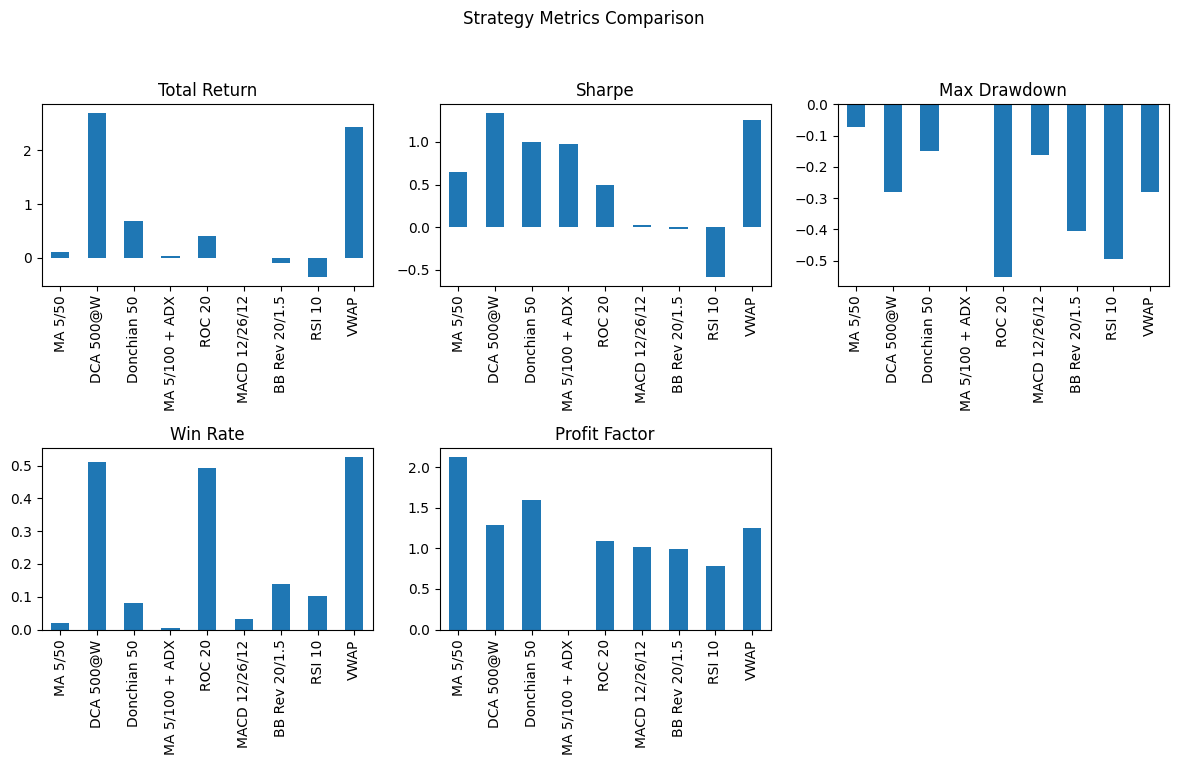

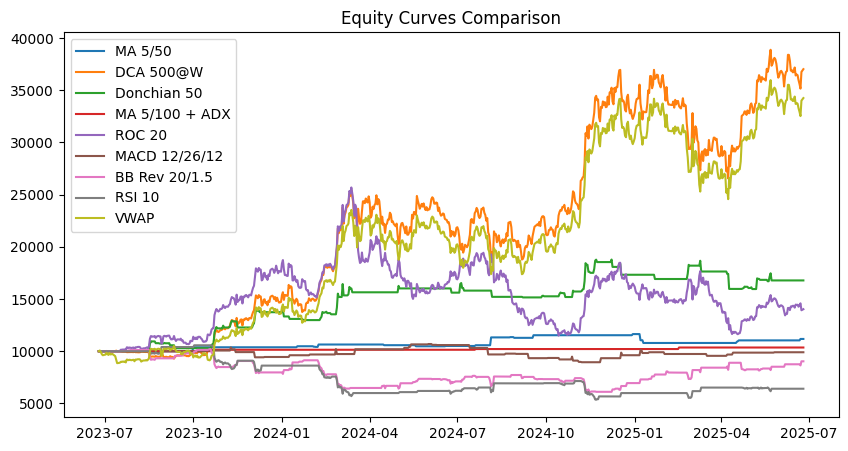

In [ ]:
# 2) Define parameter grids
param_grids = {
    'MA Cross': (
        MovingAverageCrossStrategy,
        {'short_window': [5, 20, 50], 'long_window': [50, 100, 200]}
    ),
    'DCA': (
        DcaStrategy,
        {'amount': [500, 1000, 2000], 'freq': ['D', 'W', 'M']}
    ),
    'Donchian': (
        DonchianBreakoutStrategy,
        {'window': [10, 20, 50]}
    ),
    'ADX + MA': (
        ADXTrendStrategy,
        {'short_w': [5, 20], 'long_w': [50, 100], 'adx_w': [14, 20]}
    ),
    'ROC': (
        ROCStrategy,
        {'window': [5, 10, 20]}
    ),
    'MACD': (
        MACDStrategy,
        {'fast': [8, 12], 'slow': [26, 30], 'signal': [9, 12]}
    ),
    'BB Mean Reversion': (
        BollingerMeanRevStrategy,
        {'window': [10, 20], 'n_std': [1.5, 2, 2.5]}
    ),
    'RSI': (
        RSIStrategy,
        {'window': [10, 14, 20], 'low': [30], 'high': [70]}
    ),
    'Pair Trading': (
        PairTradingStrategy,
        {'pair': [('BTC-USD','ETH-USD')], 'window': [20, 30], 'entry_z': [1.5, 2], 'exit_z': [0, 0.5]}
    ),
    'VWAP': (
        VWAPStrategy,
        {}  # no tunable params
    )
}

best_specs      = {}
best_equities   = {}
best_strategies = {}

# 3) Find the best Sharpe param set for each, via 3 methods
for type_name, (cls, grid) in param_grids.items():
    print(f"\nProcessing strategy type: {type_name}")

    # handle non-tunable
    if not grid:
        try:
            strat = cls()
            eq    = strat.backtest(data)
            sharpe = PerformanceAnalyzer(eq, strat.returns).summary()['Sharpe']
        except Exception as e:
            print(f"{type_name:20s} — all runs failed ({e}), skipping")
            continue

        display_name = strat.name
        print(f"{display_name:20s} — no params, Sharpe = {sharpe:.4f}")

        best_specs[display_name]      = {}
        best_equities[display_name]   = eq
        best_strategies[display_name] = strat
        continue

    opt = Optimizer(cls, grid)

    # --- 3a) Grid search ---
    try:
        grid_df = opt.optimize_grid(data, metric='Sharpe')
    except ValueError as e:
        print(f"{type_name:20s} — Grid: no valid combos ({e}), skipping")
        continue

    # get typed best params from grid
    params_grid = opt.best_params(grid_df, idx=0)
    sharpe_grid = grid_df.loc[0, 'Sharpe']
    print(f"  Grid best    — Sharpe {sharpe_grid:.4f} with {params_grid}")

    # --- 3b) Bayesian optimization (Optuna) ---
    try:
        params_bayes, sharpe_bayes, study = opt.optimize_bayesian(
            data, metric='Sharpe', n_trials=40, seed=42
        )
        print(f"  Bayesian best— Sharpe {sharpe_bayes:.4f} with {params_bayes}")
    except Exception as e:
        print(f"  Bayesian     — failed ({e})")

    # --- 3c) Differential Evolution (SciPy) ---
    if any(not all(isinstance(v,(int,float)) for v in choices)
        for choices in grid.values()):
        print("Skipping DE: non-numeric parameters present")
    else:
        try:
            params_de, sharpe_de, de_res = opt.optimize_de(
                data, metric='Sharpe', maxiter=20, popsize=5
            )
            print(f"  DE best      — Sharpe {sharpe_de:.4f} with {params_de}")
        except Exception as e:
            print(f"  DE           — failed ({e})")

    # final: backtest the grid champion
    strat = cls(**params_grid)
    eq    = strat.backtest(data)
    disp_name = strat.name  # includes params

    best_specs[disp_name]      = params_grid
    best_equities[disp_name]   = eq
    best_strategies[disp_name] = strat

# 4) If nothing succeeded, exit
if not best_equities:
    print("No valid strategies found. Exiting.")
    exit()

# 5) Compare grid-search best strategies
analyzers = {
    name: PerformanceAnalyzer(eq, best_strategies[name].returns)
    for name, eq in best_equities.items()
}

rep_mgr = ReportManager(directory=REPORT_DIR)
comparison_df = rep_mgr.summarize(
    analyzers,
    save=False,
    do_print=True
)

# 6) And plot
rep_mgr.plot_metrics(comparison_df)
rep_mgr.plot_equity_curves(best_equities)


# FIN